# Learing pipeline

Miguel Xochicale [@mxochicale](https://github.com/mxochicale)  
Feb2022


## 1.1 Introduction
This notebook presents prototypes to pre-process echocardiography datasets with the use of pytorch features. 

## 1.2 Running notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
## 1.3 References
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 




## 2. Jupyter Notebook

### 2.1 Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from torch.utils.data import DataLoader
from torchvision import transforms, utils

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.models.nets_misc import SimpleVideoClassifier, train_loop, test_loop
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes




HOME_PATH = os.path.expanduser(f'~')
CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files/learning_pipeline'
YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, 'config_learning_pipeline.yml')

yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler

with open(YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

### 2.2 Setting variables and loading datasets using pytorch dataloader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define some static transforms, i.e. transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_im_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=config['pretransform_im_size']),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# define some transforms for data augmentation: they have all random parameters that
# will change at each epoch.
if config['use_augmentation']:
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),  # this normalizes in
    ])
else:
    transform = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = EchoClassesDataset(main_data_path=config['main_data_path'],
                             participant_videos_list=config['participant_videos_list'],
                             participant_path_json_list=config['participant_path_json_list'],
                             crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
                             number_of_frames_per_segment_in_a_clip=config[
                                 'number_of_frames_per_segment_in_a_clip'],
                             sliding_window_length_in_percentage_of_frames_per_segment=config[
                                 'sliding_window_length_in_percentage_of_frames_per_segment'],
                             device=device,
                             max_background_duration_in_secs=config['max_background_duration_in_secs'],
                             pretransform=pretransform,
                             transform=transform,
                             use_tmp_storage=True,
                             )


print(f'Number of clips: {len(dataset)} ')



Number of clips: 18 


### 2.3 Using dataloader with pre-processing image techniques

Plotting 18 clips  and frames: 
10
   Clip number: 0; Label: BKGR   Random index in the segment clip: 18             of n_available_frames 150
   Clip number: 1; Label: BKGR   Random index in the segment clip: 46             of n_available_frames 151
   Clip number: 2; Label: BKGR   Random index in the segment clip: 76             of n_available_frames 150
   Clip number: 3; Label: BKGR   Random index in the segment clip: 87             of n_available_frames 150
   Clip number: 4; Label: BKGR   Random index in the segment clip: 44             of n_available_frames 151
   Clip number: 5; Label: BKGR   Random index in the segment clip: 93             of n_available_frames 150
   Clip number: 6; Label: BKGR   Random index in the segment clip: 128             of n_available_frames 150
   Clip number: 7; Label: BKGR   Random index in the segment clip: 31             of n_available_frames 70
   Clip number: 8; Label: BKGR   Random index in the segment clip: 111             of n_available_fra

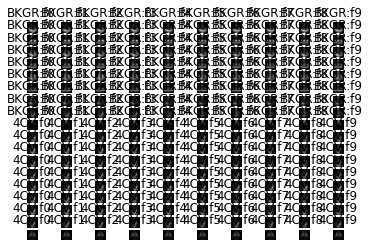

In [3]:
# Plotting all clips of the Echo classes
plot_dataset_classes(dataset, config)


In [4]:
print(f'Loaded EchoClassesDataset with {len(dataset)} clips ')
data_clip00 = dataset[0]
train_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=config['batch_size'], shuffle=True)
print(type(train_dataloader))

## Setting up model
data_size = tuple(data_clip00[0].shape)
print(type(data_size))
print(data_size)
model_net = SimpleVideoClassifier(data_size)
model_net.to(device)
print(model_net)

optimizer = torch.optim.Adam(model_net.parameters())  # use default settings
loss_function = torch.nn.CrossEntropyLoss()

for epoch in range(config['max_epochs']):
    print(f'Epoch {epoch + 1}\n-------------------------------')
    train_loop(train_dataloader, model_net, loss_function, optimizer, device)
    test_loop(test_dataloader, model_net, loss_function, device)

print(f'Done!')


Loaded EchoClassesDataset with 18 clips 
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'tuple'>
(1, 10, 128, 128)
SimpleVideoClassifier(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=163840, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=2, bias=True)
    (4): Sigmoid()
  )
)
Epoch 1
-------------------------------
loss: 0.690583
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.686768 

Epoch 2
-------------------------------
loss: 0.687907
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.685550 

Epoch 3
-------------------------------
loss: 0.686967
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.568518 

Epoch 4
-------------------------------
loss: 0.643744
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.503004 

Epoch 5
-------------------------------
loss: 0.665554
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.611170 

Epoch 6
-------------------------------
loss: 0.580893
Test Error: 
 Accuracy: 50.0%

Test Error: 
 Accuracy: 83.3%, Avg loss: 0.503208 

Epoch 76
-------------------------------
loss: 0.628204
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.503206 

Epoch 77
-------------------------------
loss: 0.671113
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.481559 

Epoch 78
-------------------------------
loss: 0.533233
Test Error: 
 Accuracy: 66.7%, Avg loss: 0.543109 

Epoch 79
-------------------------------
loss: 0.550693
Test Error: 
 Accuracy: 55.6%, Avg loss: 0.503545 

Epoch 80
-------------------------------
loss: 0.503206
Test Error: 
 Accuracy: 61.1%, Avg loss: 0.503265 

Epoch 81
-------------------------------
loss: 0.628208
Test Error: 
 Accuracy: 55.6%, Avg loss: 0.539079 

Epoch 82
-------------------------------
loss: 0.604206
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.456797 

Epoch 83
-------------------------------
loss: 0.503204
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.550690 

Epoch 84
-------------------------------
loss: 0.503204
Test Error: 
 Accuracy: 77.8

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693147 

Epoch 156
-------------------------------
loss: 0.693147
Test Error: 
 Accuracy: 44.4%, Avg loss: 0.693147 

Epoch 157
-------------------------------
loss: 0.693147
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693147 

Epoch 158
-------------------------------
loss: 0.693147
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693147 

Epoch 159
-------------------------------
loss: 0.693147
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693147 

Epoch 160
-------------------------------
loss: 0.693147
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693147 

Epoch 161
-------------------------------
loss: 0.693147
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693147 

Epoch 162
-------------------------------
loss: 0.693147
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693147 

Epoch 163
-------------------------------
loss: 0.693147
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693147 

Epoch 164
-------------------------------
loss: 0.693147
Test Error: 
 Accur